## 理解图像特征

基本上来说角点是一个好的图像特征。(不仅仅是角点，有些情况斑点也是好的图像特征。)   
找到图像特征的技术被称为`特征检测`。     
计算机要对特征周围的区域进行描述，这样它才能在其他图像中找到相同的特征。我们把这种描述称为`特征描述`。

## Harris 角点检测

Open 中的函数cv2.cornerHarris() 可以用来进行角点检测。参数如下：  
• img - 数据类型为float32 的输入图像。  
• blockSize - 角点检测中要考虑的领域大小。  
• ksize - Sobel 求导中使用的窗口大小  
• k - Harris 角点检测方程中的自由参数虽取值参数为[0,04 ，0.06].  

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

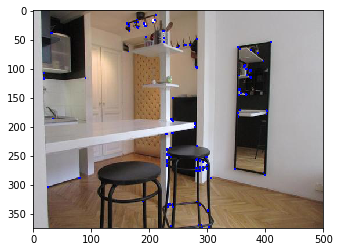

In [6]:
img = cv2.imread('./image/corner.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#输入图像必须是float32
img_gray = np.float32(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
img_harris = cv2.cornerHarris(img_gray,2,3,0.04)
img_harris = cv2.dilate(img_harris , None)     #膨胀　提升后续图像角点标注的清晰准确度　　可有可无
#print(img_harris)
thres = 0.03 * np.max(img_harris)
img[img_harris > thres] = [0, 0, 255]   #阈值　当大于这个阈值分数的都可以判定为角点
plt.imshow(img)
plt.show()

## Shi-Tomasi 角点检测

适合于跟踪的图像特征，采用打分函数R=min(lambuda1,lambuda2).   
cv2.goodFeatureToTrack()   
• img - 输入灰度图像。  
• size - 确定角点数目。  
• level - 角点质量水平，0-1之间，低于这个数角点被忽略。  
• dis - 两个角点之间的最短欧式距离

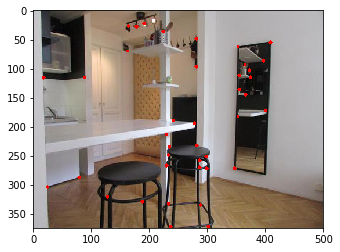

In [8]:
img = cv2.imread('./image/corner.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(img_gray,40,0.01,10)   #返回数组
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)
plt.imshow(img)
plt.show()

## SIFT

角点检测技术，比如Harris等。它们具有旋转不变特性，即使图片发生了旋转，我们也能找到同样的角点。但角点不具有尺度不变性。   
D.Lowe 提出了一个新的算法：尺度不变特征变换（SIFT），这个算法可以帮助我们提取图像中的`关键点`并计算它们的`描述符`。  
sift步骤：
1. 尺度空间生成
2. 尺度空间极值检测
3. 关键点(极值点)定位
4. 关键点(极值点)指定方向参数
5. 关键点描述符

In [45]:
img = cv2.imread('./image/1Hill.JPG')
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(img,None)   # 可以在图像中找到关键点
kp,des = sift.compute(img,kp)   #des是描述子   用于拼接等
print(des.shape)
print(len(kp))
#sift.detectAndCompute(img,None)   #一步计算#kp, des

(1257, 128)
1257


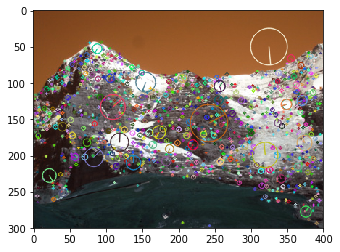

In [16]:
#flags :会绘制代表关键点大小的圆圈甚至可以绘制除关键点的方向
#src_img, keypoints,outImage,color,flags
img = cv2.drawKeypoints(img,kp,outImage=np.array([]),flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
plt.imshow(img)
plt.show()

## SURF

SIFT算法进行关键点检测和描述。这种算法的执行速度比较慢。   
SURF是加速版的SIFT。  
SURF 善于处理具有模糊和旋转的图像，但是不善于处理视角变化和光照变化。   

In [76]:
img = cv2.imread('./image/corner.jpg')
surf = cv2.xfeatures2d.SURF_create()
kp,des = surf.detectAndCompute(img,None)
len(kp)   #关键点数量,1004太多了


1004

In [77]:
#print(surf.getHessianThreshold())   #100.0  获取Hessian矩阵
surf.setHessianThreshold(8000)  #提高Hessian的阈值
kp,des = surf.detectAndCompute(img,None)
len(kp)

48

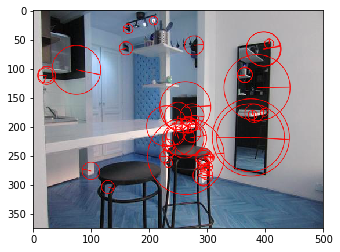

In [78]:
img1 = cv2.drawKeypoints(img,kp,None,(255,0,0),4)  #src_img, keypoints,outImage,color,flags
plt.imshow(img1)
plt.show()

U_SURF:不会检测关键点的方向

In [79]:
print(surf.getUpright())   # 0：计算方向，  1：不计算方向

False


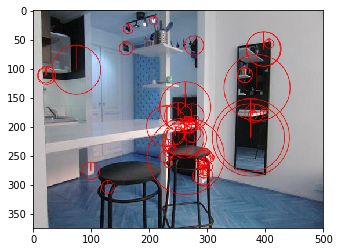

In [80]:
surf.setUpright(True)
kp = surf.detect(img,None)
img2 = cv2.drawKeypoints(img,kp,None,(255,0,0),4)
plt.imshow(img2)
plt.show()
#print(surf.getUpright())
#所有关键点朝向一致

In [82]:
print(surf.descriptorSize())  #关键点描述符大小

64


In [83]:
surf.getExtended()   # 0:64维   1:128维

False

In [84]:
surf.setExtended(True)
kp,des = surf.detectAndCompute(img,None)
des.shape

(48, 128)

## 特征匹配

### Brute-Force匹配

暴力匹配器是很简单的。首先在第一幅图像中选取一个关键点然后依次与第二幅图像的每个关键点进行(描述符)距离测试，最后范湖距离最近的关键点。    

cv2.BFMatcher()创建一个BF-Matcher对象。它有两个可选参数。第一个是normType。它是用来指定要使用的距离测试类型。默认值为 cv2.Norm_L2   
第二个参数是布尔变量crossCheck，默认值为False 。如果设置为True，匹配条件就会更加严格。   

BFMatcher对象具有两个方法，BFMatcher.match()和BFMatcher.knnMatch()。   
第一个方法会返回最佳匹配。第二个方法为每个关键点返回k个最佳匹配(降序排列之后取前k个).  

就像使用cv2.drawKeypoints() 绘制关键点一样，我们可以使用cv2.drawMatches()来绘制匹配的点。它会将这两幅图像先水平排列，然后   
在最佳匹配的点之间绘制直线(从原图像到目标图像)。如果前面使用的是BF-Matcher.knnMatch()，现在我们可以使用函数cv2.drawMatchsKnn   
为每个关键点和它的k个最佳匹配点绘制匹配线。如果k等于2，就会为每个关键点绘制两条最佳匹配直线。  

匹配器对象：   
matches = bf.match( des1,des2) 返回值是一个DMatch对象列表。这个DMatch对象具有下列属性：   
• DMatch.distance - 描述符之间的距离。越小越好。   
• DMatch.trainIdx - 目标图像中描述符的索引。   
• DMatch.queryIdx - 查询图像中描述符的索引。   
• DMatch.imgIdx   - 目标图像的索引。   

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

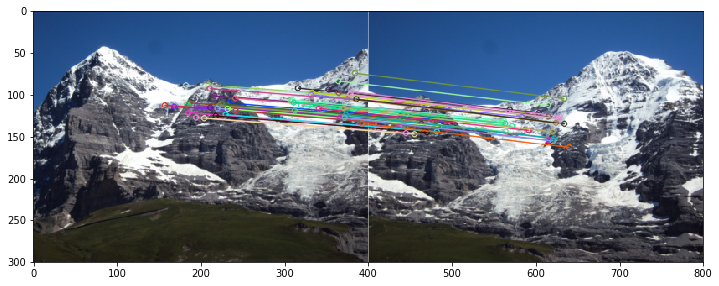

In [12]:
img1 = cv2.imread('./image/1Hill.JPG')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

img2 = cv2.imread('./image/2Hill.JPG')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

sift = cv2.xfeatures2d.SIFT_create()

kp1,des1 = sift.detectAndCompute(img1,None)
kp2,des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()  #创建匹配器对象
matches = bf.knnMatch(des1,des2,k=2)  #返回匹配点

# Apply ratio test
# 比值测试，首先获取与A 点离最近的点B（最近）和C（次近），只有当 B/C
# 小于阈值时（0.75）才被认为是匹配，因为假设匹配是一一对应的，真正的匹配的理想䞌距离为0
verified = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        verified.append([m])
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,verified[:50],None,flags=2)
plt.figure(figsize=(12,8))
plt.imshow(img3)
plt.show()

### FLANN匹配器

FLANN对大数据集和高维特征进行最邻近搜索的算法的集合，面对大数据集时它的效果要好于BFMatcher。   
使用FLANN 匹配，我们需要传入两个字典作为参数：   
第一个是 IndexParams 。对于SIFT和SURF等，传入的参数是:   
indexparams = dict ( algorithm = FLANNINDEXKDTREE ,trees = 5)   

第二个字典是SearchParams。用它来指定递归遍历的次数。值越高结果越准确，但是消耗的时间也越多。

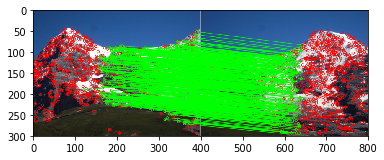

In [26]:
img1 = cv2.imread('./image/1Hill.JPG')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

img2 = cv2.imread('./image/2Hill.JPG')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

sift = cv2.xfeatures2d.SIFT_create()

kp1,des1 = sift.detectAndCompute(img1,None)
kp2,des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE,trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k = 2)

match_mask = [[0,0] for i in range(len(matches))]
for i ,(m,n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
        match_mask[i] = [1,0]
        
draw_params = dict(matchColor = (0,255 ,0),singlePointColor = (255 ,0,0),matchesMask = match_mask,flags = 0)
img3 = cv2 .drawMatchesKnn(img1,kp1,img2,kp2,matches, None,**draw_params)
plt .imshow(img3)
plt.show()

## 使用特征匹配和单应性查找对象

联合使用特征提取和calib3d 模块中的findHomography 在复杂图像中查找已知对象

In [53]:
img1 = cv2.imread('./image/1Hill.JPG')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

img2 = cv2.imread('./image/2Hill.JPG')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

#找到特征点
sift = cv2.xfeatures2d.SIFT_create()
kp1,des1 = sift.detectAndCompute(img1,None)
kp2,des2 = sift.detectAndCompute(img2,None)

#flann  特征点匹配
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE,trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k = 2)

verified = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        verified.append(m)

min_match_count = 8
if len(verified) > min_match_count:
    # 获取关键点的坐标
    #img1 -> img2
    src_pts = np.float32([kp1[m.queryIdx].pt for m in verified]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in verified]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts,dst_pts,cv2.RANSAC,5.0)
#第四个参数取值范围在1 到10,拒绝一个点对的阈值

In [57]:
matchesMask = mask.ravel().tolist()
h,w ,c= img1.shape
#使用得到的变换矩俤对原图像的四个角进行变换，获得在目标图像上对应的坐标。
pts = np.float32([ [ 0,0],[ 0,h-1],[w-1,h-1],[w-1,0] ]).reshape( -1,1,2)
dst = cv2.perspectiveTransform(pts,M)
cv2 .polylines(img2,[np.int32(dst)],True,255 ,10, cv2.LINE_AA)

array([[[188, 196, 209],
        [126, 144, 168],
        [123, 152, 184],
        ...,
        [130, 154, 190],
        [130, 154, 190],
        [130, 154, 190]],

       [[119, 142, 183],
        [ 35,  69, 117],
        [ 21,  66, 123],
        ...,
        [ 35,  77, 135],
        [ 34,  76, 136],
        [ 34,  76, 136]],

       [[127, 149, 186],
        [ 31,  63, 110],
        [ 20,  63, 118],
        ...,
        [ 36,  77, 139],
        [ 36,  77, 139],
        [ 35,  76, 138]],

       ...,

       [[126, 125, 120],
        [ 26,  25,  20],
        [ 26,  26,  18],
        ...,
        [ 36,  34,  39],
        [ 37,  34,  41],
        [ 38,  35,  42]],

       [[126, 125, 120],
        [ 26,  26,  18],
        [ 25,  25,  17],
        ...,
        [ 42,  40,  45],
        [ 40,  39,  45],
        [ 39,  38,  44]],

       [[126, 126, 118],
        [ 25,  25,  17],
        [ 25,  25,  17],
        ...,
        [ 38,  37,  43],
        [ 35,  36,  41],
        [ 33,  33,  41]]

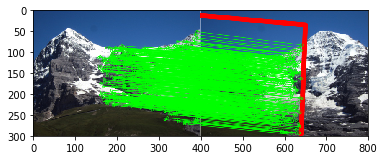

In [58]:
draw_params = dict(matchColor = (0,255 ,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,verified,None,**draw_params)
plt .imshow(img3)
plt.show()